In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import sys
import os
core_dir = os.path.join(os.getcwd(), '..')
core_dir = os.path.normpath(core_dir)
sys.path.append(core_dir)
core_dir = os.path.join(os.getcwd(), '..', 'daphme')
core_dir = os.path.normpath(core_dir)
sys.path.append(core_dir)

import pdb

In [10]:
synth_data = pd.read_parquet('s3://synthetic-raw-data/100-agents/sparse_trajectories.parquet')
synth_data['local_timestamp'] = pd.to_datetime(synth_data['timestamp'], unit='s')

In [11]:
synth_data

,uid,timestamp,latitude,longitude,local_timestamp
0,wizardly_joliot,1704119340,38.321711,-36.667334,2024-01-01 14:29:00
1,wizardly_joliot,1704119700,38.321676,-36.667365,2024-01-01 14:35:00
2,wizardly_joliot,1704155880,38.320959,-36.666748,2024-01-02 00:38:00
3,wizardly_joliot,1704156000,38.320936,-36.666739,2024-01-02 00:40:00
4,wizardly_joliot,1704156840,38.320924,-36.666747,2024-01-02 00:54:00
...,...,...,...,...,...
1691,angry_spence,1705303380,38.320399,-36.667438,2024-01-15 07:23:00
1692,angry_spence,1705303740,38.320413,-36.667469,2024-01-15 07:29:00
1693,angry_spence,1705303980,38.320384,-36.667455,2024-01-15 07:33:00
1694,angry_spence,1705304340,38.320349,-36.667473,2024-01-15 07:39:00


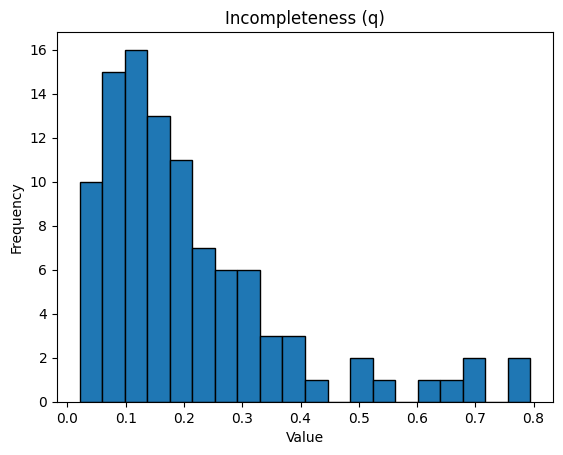

In [12]:
def q_stat(group):
    sparse_hours = group['local_timestamp'].dt.to_period('h')
    num_hours = sparse_hours.nunique()
    total_hours = 24 * 14
    q_stat_value = num_hours / total_hours
    return q_stat_value

q_stats = synth_data.groupby('uid').apply(q_stat, include_groups=False)

plt.hist(q_stats, bins=20, edgecolor='black')

plt.title('Completeness (q)')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

In [15]:
daily_active_users = synth_data.groupby(synth_data['local_timestamp'].dt.date)['uid'].nunique()
np.mean(daily_active_users)

80.86666666666666

In [16]:
daily_active_users

local_timestamp
2024-01-01    73
2024-01-02    89
2024-01-03    85
2024-01-04    79
2024-01-05    79
2024-01-06    84
2024-01-07    83
2024-01-08    76
2024-01-09    79
2024-01-10    83
2024-01-11    87
2024-01-12    82
2024-01-13    89
2024-01-14    90
2024-01-15    55
Name: uid, dtype: int64

In [23]:
# Persistence, measured by conditional probability
# Pr[X[n+tau] = 1 | X[n] = 1]

def persistence(df, tau):
    df['hour'] = df['local_timestamp'].dt.floor('h')
    df_hourly = df.groupby(['uid', 'hour']).size().clip(upper=1).reset_index(name='ping')

    # Generate a complete range of hours for each user
    all_hours_list = []
    for uid in df['uid'].unique():
        uid_hours = pd.date_range(start=pd.Timestamp('2024-01-01 08:00:00'), 
                                  end=pd.Timestamp('2024-01-15 07:00:00'), freq='h')
        all_hours_df = pd.DataFrame({'hour': uid_hours})
        all_hours_df['uid'] = uid
        all_hours_list.append(all_hours_df)

    all_hours_complete = pd.concat(all_hours_list, ignore_index=True)

    df_complete = pd.merge(all_hours_complete, df_hourly, on=['uid', 'hour'], how='left').fillna(0)
    df_complete['ping'] = df_complete['ping'].astype(int)

    df_complete['lag_ping'] = df_complete.groupby('uid')['ping'].shift(-tau)

    numerator = ((df_complete['ping'] == 1) & (df_complete['lag_ping'] == 1)).sum()
    denominator = (df_complete['ping'] == 1).sum()

    conditional_prob = numerator / denominator if denominator > 0 else 0

    return conditional_prob

persistence(synth_data, 1)

0.637748624629708